In [1]:
import os
import json
import fnmatch
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


/tmp/ipykernel_19221/1034509118.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [124]:
# Paths to run in cluster.
# ROOT_GPCRMD = "/files_gpcrmd"

# Paths to run locally.
PROJECT_ROOT = "/home/alex/Documents/pocket_tool"
ROOT_GPCRMD = "/home/alex/sshfs_mountpoints/gpcrmd"
pocket_dir = "/home/alex/sshfs_mountpoints/mdpocket_oversized/"

COMPL_INFO_PATH = os.path.join(ROOT_GPCRMD, "media/files/Precomputed/compl_info.json")


Mount the GPCRmd directory with: 

`sshfs aperalta@gwaihir.prib.upf.edu:/data/GPCRmd/ /home/alex/sshfs_mountpoints/gpcrmd/`

Mount oversized folder with:

`sshfs aperalta@ori.prib.upf.edu:/DATA/protwis/sites/files/Precomputed/MDpocket_oversized /home/alex/sshfs_mountpoints/mdpocket_oversized/`

<!-- Mount verde home with: -->

<!-- `sshfs aperalta@verde.prib.upf.edu:/home/aperalta/ /home/alex/sshfs_mountpoints/verde` -->

In [125]:
def read_dynid_trajids():
    trajid_dict = {}
    trajids_path = os.path.join(PROJECT_ROOT, "data/working_sims/data/dynids_trajids.csv")
    with open(trajids_path, 'r') as file:
        next(file) # Skip header line
        for line in file:
            dynid, trajid = line.strip().split(';')
            if dynid in trajid_dict:
                trajid_dict[dynid].append(trajid)
            else:
                trajid_dict[dynid] = [trajid]
    return trajid_dict


def read_json_into_dict(json_path):
    """
    Reads a JSON file and returns the data as a dictionary.
    """
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data


def read_descriptors_file(file_path):
    """
    Read a tab-separated file and return a dictionary where each key is a
    column name and each value is a list of column values.

    Args:
        file_path (str): Path to the tab-separated file.

    Returns:
        dict: A dictionary with column names as keys and lists of values as
        values.
    """
    values = {}
    fh = open(file_path, 'r')

    # Read the header line and initialize the values dictionary
    header = fh.readline()
    for field in header.split():
        values[field] = []
    
    # Read the rest of the file and populate the values dictionary
    for line in fh:
        fields = line.split()
        for i, field in enumerate(header.split()):
            values[field].append(fields[i])

    fh.close()
    return values


def moving_average(data, window_size):
    """
    Calculate the moving average of a list of numbers.

    Args:
        data (list): List of numbers.
        window_size (int): Size of the moving average window.

    Returns:
        list: List of moving averages.
    """
    if not data or window_size <= 0:
        return []

    cumsum = [0] * (len(data) + 1)
    for i, x in enumerate(data):
        cumsum[i + 1] = cumsum[i] + x

    return [(cumsum[i + window_size] - cumsum[i]) / window_size
            for i in range(len(data) - window_size + 1)]


def find(pattern, path):
    """
    Find all files matching a given pattern in a directory and its
    subdirectories.

    Args:
        pattern (str): The pattern to match files against.
        path (str): The directory path to search in.
    Returns:
        generator: A generator yielding paths of files that match the pattern.
    """
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                yield os.path.join(root, name)


def extract_ids(path):
    """
    Extracts trajectory ID, dynID, and pocket ID from a given file path.
    
    Parameters:
        path (str): The full file path.
        
    Returns:
        dict: A dictionary with keys 'trajectory_id', 'dyn_id', and 'pocket_id'.
    """
    # Match descriptorPockets_<traj_id>_trj_<dyn_id>.xtc
    trajectory_match = re.search(r'descriptorPockets_(\d+)_trj_(\d+)\.xtc', path)
    # Match pocket_num_<pocket_id>_descriptors.txt
    pocket_match = re.search(r'pocket_num_(\d+)_descriptors\.txt', path)

    if trajectory_match and pocket_match:
        traj_id = trajectory_match.group(1)
        dyn_id = trajectory_match.group(2)
        pocket_id = pocket_match.group(1)

        return (traj_id, dyn_id, pocket_id)
    else:
        print(f"Could not extract all required IDs from the path: {path}.")
        return None, None, None

## Dataset description

In [126]:
compl_info = read_json_into_dict(COMPL_INFO_PATH)

dynid_info = {
    'prot_sname': [],
    'class': [],
    'lig_lname': [],
    'prot_lname': [],
    'up_name': [],
    'pdb_id': []
}
for dynid, trajids in read_dynid_trajids().items():
    dynid_key = f'dyn{dynid}'
    prot_sname = compl_info[dynid_key]['prot_sname']
    gpcr_class = compl_info[dynid_key]['class']
    lig_lname = compl_info[dynid_key]['lig_lname']
    prot_lname = compl_info[dynid_key]['prot_lname']
    up_name = compl_info[dynid_key]['up_name']
    pdb_id = compl_info[dynid_key]['pdb_id']
    # print(compl_info[dynid_key])

    dynid_info['prot_sname'].append(prot_sname)
    dynid_info['class'].append(gpcr_class)
    dynid_info['lig_lname'].append(lig_lname)
    dynid_info['prot_lname'].append(prot_lname)
    dynid_info['up_name'].append(up_name)
    dynid_info['pdb_id'].append(pdb_id)

df = pd.DataFrame(dynid_info)

In [120]:
df

,prot_sname,class,lig_lname,prot_lname,up_name,pdb_id
0,glr_human,B,Pro-glucagon [Cleaved into: Glicentin; Glicent...,Glucagon receptor,glr_human,5YQZ
1,lpar1_human,A,False,Lysophosphatidic acid receptor 1,lpar1_human,4Z35.A
2,adrb2_human,A,(-)-Alprenolol,Beta-2 adrenergic receptor,adrb2_human,3NYA.A
3,nk1r_human,A,False,Substance-P receptor,nk1r_human,6J20
4,lpar1_human,A,ONO9780307,Lysophosphatidic acid receptor 1,lpar1_human,4Z34.A
...,...,...,...,...,...,...
540,5ht2a_human,A,Zotepine,5-hydroxytryptamine receptor 2A,5ht2a_human,6A94
541,ccr5_human,A,False,C-C chemokine receptor type 5,ccr5_human,6AKY
542,opsd_bovin,A,False,Rhodopsin,opsd_bovin,6FKB
543,pth1r_human,B,Parathyroid hormone,Parathyroid hormone/parathyroid hormone-relate...,pth1r_human,6NBF


In [121]:
n_dyndids = len(df)
n_trajids = len(get_trajids())
n_uniprotids = len(df['up_name'].unique())
n_systems_wligands = len(df[df['lig_lname'] != False])
n_receptors = len(df['prot_lname'].unique())
n_pdbs = len(df['pdb_id'].unique())
n_classes = len(df['class'].unique())
n_classes_counts = df['class'].value_counts()

print(f'Number of systems: {n_dyndids}')
print(f'Number of trajectories: {n_trajids}')
print(f'Number of unique Uniprot IDs: {n_uniprotids}')
print(f'Number of systems with ligands: {n_systems_wligands}')
print(f'Number of unique PDB IDs: {n_pdbs}')
print(f'Number of unique classes: {n_classes}')
print('Counts of unique classes:')
print(n_classes_counts)

Number of systems: 545
Number of trajectories: 1629
Number of unique Uniprot IDs: 66
Number of systems with ligands: 255
Number of unique PDB IDs: 286
Number of unique classes: 4
Counts of unique classes:
class
A    481
F     32
B     23
C      9
Name: count, dtype: int64


## Descriptors plotting

### Creating pocket descriptors file

Run only if file is not generated (it takes ~1-2h to run)

In [194]:
df_dict = {
    'frame': [],
    'dyn_id': [],
    'traj_id': [],
    'pocket_id': [],
    'pock_volume': [],
    'pock_pol_asa': [],
    'pock_apol_asa': []}

dynids_trajids = read_dynid_trajids()

for index, file in enumerate(find("pocket_num_*_descriptors.txt", pocket_dir)):

    # if index > 200:
    #     break

    try:
        # Extract IDs from the file path
        traj_id, dyn_id, pocket_id = extract_ids(file)
        if traj_id == None:
            continue

        # Skip if not in our set
        if dyn_id not in dynids_trajids.keys():
            continue

        if traj_id not in dynids_trajids[dyn_id]:
            continue

        # if not (dyn_id == "8" and traj_id == "10170" and pocket_id == "8"):
        #     continue

        # Get the volumes and smooth them
        values_dict = read_descriptors_file(file)
        for frame in range(len(values_dict['pock_volume'])):
            volume = float(values_dict['pock_volume'][frame])
            pock_pol_asa = float(values_dict['pock_pol_asa'][frame])
            pock_apol_asa = float(values_dict['pock_apol_asa'][frame])
            # smoothed_volume = moving_average(volumes, window_size=20)

            # Append the data to the dictionary
            df_dict['frame'].append(frame)
            df_dict['dyn_id'].append(dyn_id)
            df_dict['traj_id'].append(traj_id)
            df_dict['pocket_id'].append(pocket_id)
            df_dict['pock_volume'].append(volume)
            df_dict['pock_pol_asa'].append(pock_pol_asa)
            df_dict['pock_apol_asa'].append(pock_apol_asa)

    except Exception as e:
        print(f"Error processing file {file} (index {index}): {e}")
        continue

df = pd.DataFrame(df_dict)

df.to_csv('pocket_descriptors.csv', index=False)

Could not extract all required IDs from the path: /home/alex/sshfs_mountpoints/mdpocket_oversized/10140_trj_4.dcd_mdpocket/descriptorPockets_10140_trj_4.dcd/pocket_num_0_descriptors.txt.
Could not extract all required IDs from the path: /home/alex/sshfs_mountpoints/mdpocket_oversized/10140_trj_4.dcd_mdpocket/descriptorPockets_10140_trj_4.dcd/pocket_num_10_descriptors.txt.
Could not extract all required IDs from the path: /home/alex/sshfs_mountpoints/mdpocket_oversized/10140_trj_4.dcd_mdpocket/descriptorPockets_10140_trj_4.dcd/pocket_num_11_descriptors.txt.
Could not extract all required IDs from the path: /home/alex/sshfs_mountpoints/mdpocket_oversized/10140_trj_4.dcd_mdpocket/descriptorPockets_10140_trj_4.dcd/pocket_num_12_descriptors.txt.
Could not extract all required IDs from the path: /home/alex/sshfs_mountpoints/mdpocket_oversized/10140_trj_4.dcd_mdpocket/descriptorPockets_10140_trj_4.dcd/pocket_num_13_descriptors.txt.
Could not extract all required IDs from the path: /home/alex/

### Reading pocket descriptors

Run if the file is already generated

#### Try with smoothing (not working)

In [195]:
df = pd.read_csv('pocket_descriptors.csv')
# Add the frame number (it was missing when generating the CSV)
df['frame'] = df.groupby(['dyn_id', 'traj_id', 'pocket_id']).cumcount()

window_size = 10
def moving_average_padded(x, window_size):
    ma = moving_average(list(x), window_size)
    # Pad with NaNs at the start so the length matches
    return [np.nan] * (window_size - 1) + ma

df_smooth = df.copy()
df_smooth['pock_volume'] = df.groupby(['dyn_id', 'traj_id', 'pocket_id'])['pock_volume'].transform(
    lambda x: moving_average_padded(x, window_size))
df_smooth['pock_pol_asa'] = df.groupby(['dyn_id', 'traj_id', 'pocket_id'])['pock_pol_asa'].transform(
    lambda x: moving_average_padded(x, window_size))
df_smooth['pock_apol_asa'] = df.groupby(['dyn_id', 'traj_id', 'pocket_id'])['pock_apol_asa'].transform(
    lambda x: moving_average_padded(x, window_size))

# # Drop rows with NaN values in any of the smoothed columns
# df_smooth = df_smooth.dropna(subset=['pock_volume', 'pock_pol_asa', 'pock_apol_asa'])

KeyboardInterrupt: 

In [186]:
df_means = df_smooth.groupby(['dyn_id', 'traj_id', 'pocket_id']).mean().reset_index()
df_max = df_smooth.groupby(['dyn_id', 'traj_id', 'pocket_id']).max().reset_index()
df_min = df_smooth.groupby(['dyn_id', 'traj_id', 'pocket_id']).min().reset_index()

In [157]:
df_toplot = df[(df['dyn_id'] == 952) & (df['traj_id'] == 15917) & (df['pocket_id'] == 4)]
plt.plot(df_toplot['frame'], df_toplot['smooth_pock_volume'])

KeyError: 'smooth_pock_volume'

In [187]:
df_max_min = df_smooth.copy()
df_max_min['pock_volume'] = df_max['pock_volume'] - df_min['pock_volume']
df_max_min['pock_pol_asa'] = df_max['pock_pol_asa'] - df_min['pock_pol_asa']
df_max_min['pock_apol_asa'] = df_max['pock_apol_asa'] - df_min['pock_apol_asa']
df_max_min

,frame,dyn_id,traj_id,pocket_id,pock_volume,pock_pol_asa,pock_apol_asa
0,0,8,10170,0,104.895,24.652,25.126
1,1,8,10170,0,126.434,9.598,35.246
2,2,8,10170,0,79.573,39.994,29.949
3,3,8,10170,0,350.180,82.766,63.605
4,4,8,10170,0,183.745,17.466,32.365
...,...,...,...,...,...,...,...
55347,495,13,10202,16,NaN,NaN,NaN
55348,496,13,10202,16,NaN,NaN,NaN
55349,497,13,10202,16,NaN,NaN,NaN
55350,498,13,10202,16,NaN,NaN,NaN


TODO: CHECK WHY NO POCKETS 0-9

In [184]:
df_means[df_means['traj_id'] == 10202]

,dyn_id,traj_id,pocket_id,frame,pock_volume,pock_pol_asa,pock_apol_asa
110,13,10202,0,254.0,175.500075,59.240452,59.728576
111,13,10202,10,254.0,167.068680,59.318477,47.690886
112,13,10202,11,254.0,17.782788,1.355540,4.963257
113,13,10202,12,254.0,153.224363,14.192397,52.021709
114,13,10202,13,254.0,287.912986,44.545385,145.832841
115,13,10202,14,254.0,39.751660,6.790890,20.189758
116,13,10202,15,254.0,115.639232,4.841878,68.086896
117,13,10202,16,254.0,42.559515,2.475222,26.614625


#### Just mean and std

In [262]:
df = pd.read_csv('pocket_descriptors.csv')
# Add the frame number (it was missing when generating the CSV)
df['frame'] = df.groupby(['dyn_id', 'traj_id', 'pocket_id']).cumcount()

df_mean = df.groupby(['dyn_id', 'traj_id', 'pocket_id']).mean().reset_index()
df_std = df.groupby(['dyn_id', 'traj_id', 'pocket_id']).std().reset_index()


115.64602410556483


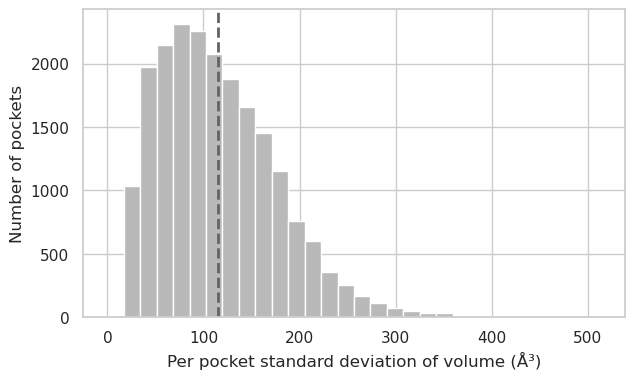

In [281]:
plt.figure(figsize=(7, 4))
sns.set(style="whitegrid")
plt.hist(df_std['pock_volume'], bins=30, color="#B9B9B9")
plt.axvline(df_std['pock_volume'].mean(), color='#636363', linestyle='dashed', linewidth=2)
# plt.axvline(0, color='grey', linestyle='solid', linewidth=2)
plt.xlabel("Per pocket standard deviation of volume (Å³)")
plt.ylabel("Number of pockets")
plt.savefig('/home/alex/Documents/pocket_tool/docs/figures/raw/pocket_volume_std_distribution.svg')
print(df_std['pock_volume'].mean())


251.94162165460753


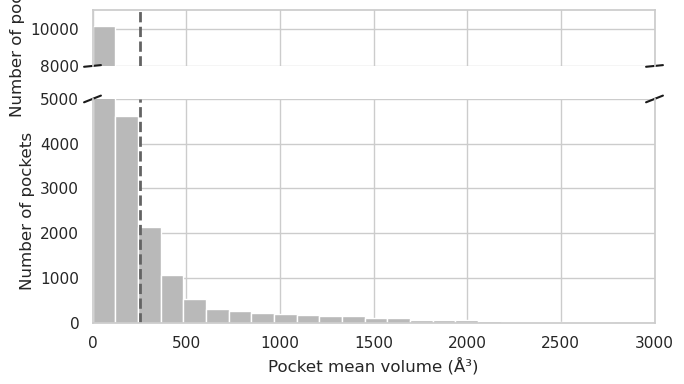

In [288]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
data = df_mean['pock_volume']

# Figure with two subplots (stacked vertically, sharing x-axis)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 4),
                               gridspec_kw={'height_ratios': [1, 4]})  # top smaller

sns.set(style="whitegrid")

# Histogram bottom (normal scale)
ax2.hist(data, bins=35, color="#B9B9B9")
ax2.axvline(data.mean(), color='#636363', linestyle='dashed', linewidth=2)

# Histogram top (only tall bar region)
ax1.hist(data, bins=35, color="#B9B9B9")
ax1.axvline(data.mean(), color='#636363', linestyle='dashed', linewidth=2)

# Set y-limits to create the "break"
ax1.set_ylim(8000, 11000)  # adjust for your tallest bar
ax2.set_ylim(0, 5000)

# Hide the spines between the two plots
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Add diagonal slashes to indicate the break
d = .015  # size of slashes
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)      # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to bottom axes
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)      # bottom-left diagonal
ax2.plot((1-d, 1+d), (1-d, 1+d), **kwargs)    # bottom-right diagonal

# Labels
ax2.set_xlabel("Pocket mean volume (Å³)")
ax2.set_ylabel("Number of pockets")
ax1.set_ylabel("Number of pockets")

plt.xlim(0,3000)

plt.tight_layout()
plt.savefig('/home/alex/Documents/pocket_tool/docs/figures/raw/pocket_volume_distribution.svg')
print(data.mean())


46.198422189566266 20.123012312889934


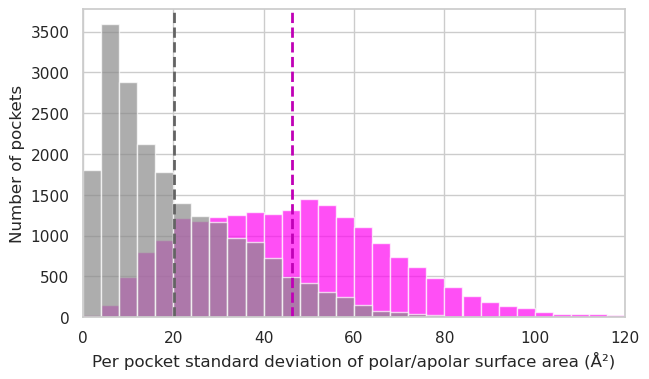

In [280]:
plt.figure(figsize=(7, 4))
sns.set(style="whitegrid")
bins = np.linspace(0, 120, 31)
plt.hist(df_std['pock_apol_asa'], bins=bins, color="#FF05F2", alpha=0.7, label='Apolar')
plt.hist(df_std['pock_pol_asa'], bins=bins, color="#8A8A8A", alpha=0.7, label='Polar')
plt.axvline(df_std['pock_apol_asa'].mean(), color="#C000B6", linestyle='dashed', linewidth=2)
plt.axvline(df_std['pock_pol_asa'].mean(), color="#636363", linestyle='dashed', linewidth=2)
plt.xlabel("Per pocket standard deviation of polar/apolar surface area (Å²)")
plt.ylabel("Number of pockets")
plt.xlim(0,120)
plt.savefig('/home/alex/Documents/pocket_tool/docs/figures/raw/pocket_asa_std_distribution.svg')
print(df_std['pock_apol_asa'].mean(), df_std['pock_pol_asa'].mean())

95.80114159311182 43.322126117330455


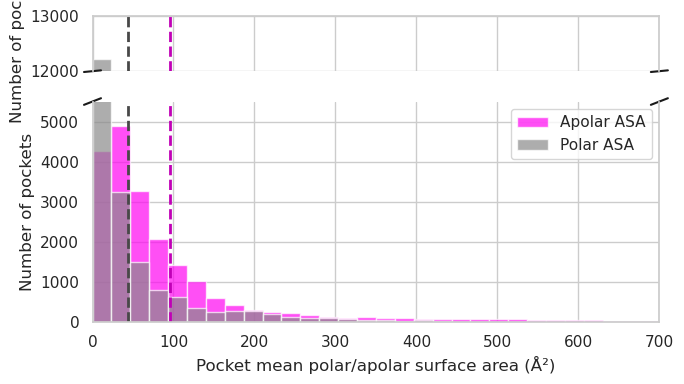

In [279]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data
apol = df_mean['pock_apol_asa']
pol = df_mean['pock_pol_asa']

# Define equal-width bins
bins = np.linspace(0, 700, 31)  # 20 equal bins from 0 to 750

# Figure with two subplots (broken axis)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 4),
                               gridspec_kw={'height_ratios': [1, 4]})

sns.set(style="whitegrid")

# Plot histograms on both axes
for ax in (ax1, ax2):
    ax.hist(apol, bins=bins, color="#FF05F2", label="Apolar ASA", alpha=0.7)
    ax.hist(pol, bins=bins, color="#8A8A8A", label="Polar ASA", alpha=0.7)
    ax.axvline(apol.mean(), color="#C000B6", linestyle='dashed', linewidth=2)
    ax.axvline(pol.mean(), color="#484848", linestyle='dashed', linewidth=2)

# Set y-limits to create the break
ax1.set_ylim(12000, 13000)  # adjust based on tallest bar
ax2.set_ylim(0, 5500)

# Hide spines between the two plots
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Add diagonal slashes for the break
d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
ax2.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

# Labels and limits
ax2.set_xlabel("Pocket mean polar/apolar surface area (Å²)")
ax2.set_ylabel("Number of pockets")
ax1.set_ylabel("Number of pockets")
ax2.set_xlim(0, 700)

# Legend
ax2.legend()

plt.tight_layout()
plt.savefig('/home/alex/Documents/pocket_tool/docs/figures/raw/pocket_asa_distribution.svg')
print(apol.mean(), pol.mean())


#### Apolar and polar ASA

In [215]:
df['apol_pol_asa_diff'] = df['pock_apol_asa'] - df['pock_pol_asa']
df['apol_pol_asa_diff_norm'] = df['apol_pol_asa_diff'] / (df['pock_apol_asa']+df['pock_pol_asa'])

df['apol_pol_asa_diff_max'] = df.groupby(['dyn_id', 'traj_id', 'pocket_id'])['apol_pol_asa_diff'].transform('max')
df['apol_pol_asa_diff_min'] = df.groupby(['dyn_id', 'traj_id', 'pocket_id'])['apol_pol_asa_diff'].transform('min')

df_means = df.groupby(['dyn_id', 'traj_id', 'pocket_id']).mean().reset_index()
df_medians = df.groupby(['dyn_id', 'traj_id', 'pocket_id']).median().reset_index()

df_means['apol_pol_asa_diff_max-mean'] = df_means['apol_pol_asa_diff_max'] - df_means['apol_pol_asa_diff']
df_means['apol_pol_asa_diff_min-mean'] = df_means['apol_pol_asa_diff_min'] - df_means['apol_pol_asa_diff']
# df_means['apol_pol_asa_diff_max-mean_norm'] = df_means['apol_pol_asa_diff_max-mean'] / df_means['apol_pol_asa_diff']

# From 24k pockets we go to 16k
df_means = df_means[(df_means['pock_volume'] > 50) & (df_medians['pock_volume'] > 10)]

In [216]:
df_means

,dyn_id,traj_id,pocket_id,pock_volume,pock_pol_asa,pock_apol_asa,frame,apol_pol_asa_diff,apol_pol_asa_diff_norm,apol_pol_asa_diff_max,apol_pol_asa_diff_min,apol_pol_asa_diff_max-mean,apol_pol_asa_diff_min-mean
0,4,10140,0,588.202890,42.224870,233.083929,153.5,190.859058,0.699133,305.36,0.00,114.500942,-190.859058
3,4,10140,3,322.504416,16.161753,157.573766,153.5,141.412013,0.827805,288.79,0.00,147.377987,-141.412013
6,4,10140,6,975.597208,178.939968,342.748799,153.5,163.808831,0.320142,274.20,38.58,110.391169,-125.228831
7,4,10140,7,224.386721,32.464026,71.861299,153.5,39.397273,0.380408,127.32,-81.14,87.922727,-120.537273
8,4,10140,8,175.459156,8.429578,82.524578,153.5,74.095000,0.827381,231.72,0.00,157.625000,-74.095000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24107,1111,18511,6,371.225260,119.401120,106.858240,249.5,-12.542880,-0.053622,110.67,-181.92,123.212880,-169.377120
24108,1111,18511,7,387.673260,88.528940,186.255400,249.5,97.726460,0.361903,208.73,-11.81,111.003540,-109.536460
24109,1111,18511,8,123.353980,52.147640,47.326340,249.5,-4.821300,-0.056475,117.21,-91.21,122.031300,-86.388700
24110,1111,18511,9,168.857940,75.350260,43.986680,249.5,-31.363580,-0.253301,73.36,-160.67,104.723580,-129.306420


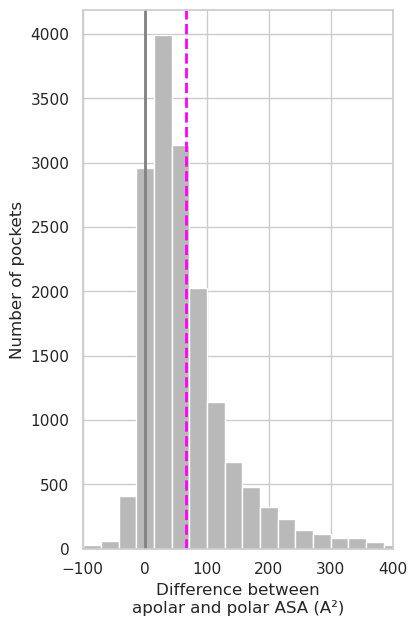

In [269]:
plt.figure(figsize=(4, 7))
sns.set(style="whitegrid")
plt.hist(df_means['apol_pol_asa_diff'], bins=45, color="#B9B9B9")
plt.axvline(df_means['apol_pol_asa_diff'].mean(), color="magenta", linestyle='dashed', linewidth=2)
plt.axvline(0, color='grey', linestyle='solid', linewidth=2)
plt.xlim(-100, 400)
plt.xlabel('Difference between\napolar and polar ASA (A²)')
plt.ylabel('Number of pockets')
plt.show()

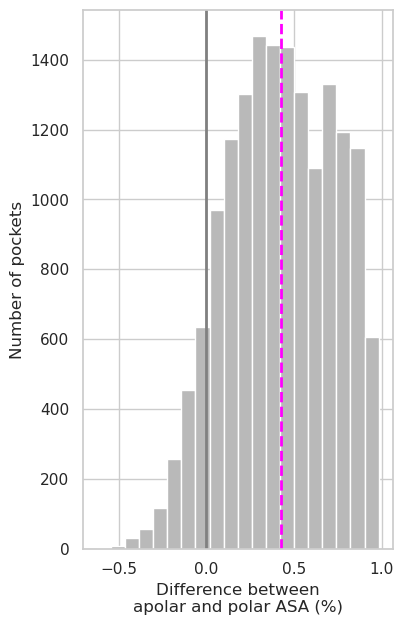

In [271]:
plt.figure(figsize=(4, 7))
sns.set(style="whitegrid")
plt.hist(df_means['apol_pol_asa_diff_norm'], bins=20, color="#B9B9B9")
plt.axvline(df_means['apol_pol_asa_diff_norm'].mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.axvline(0, color='grey', linestyle='solid', linewidth=2)
plt.xlabel("Difference between\napolar and polar ASA (%)")
plt.ylabel("Number of pockets")
plt.show()

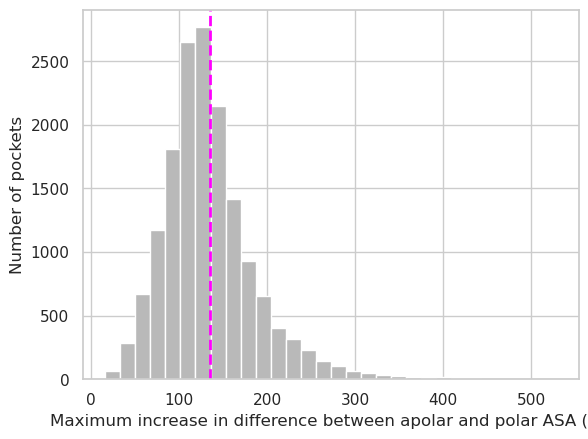

In [233]:
plt.hist(df_means['apol_pol_asa_diff_max-mean'], bins=30, color="#B9B9B9")
plt.axvline(df_means['apol_pol_asa_diff_max-mean'].mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.xlabel('Maximum increase in difference between apolar and polar ASA (A²)')
plt.ylabel('Number of pockets')
plt.show()

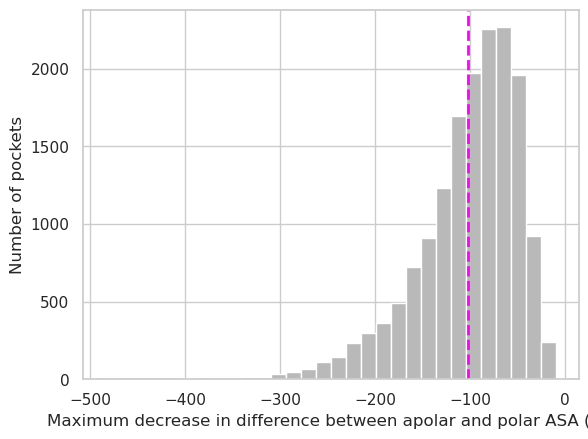

In [236]:
plt.hist(df_means['apol_pol_asa_diff_min-mean'], bins=30, color="#B9B9B9")
plt.axvline(df_means['apol_pol_asa_diff_min-mean'].mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.xlabel('Maximum decrease in difference between apolar and polar ASA (A²)')
plt.ylabel('Number of pockets')
plt.show()

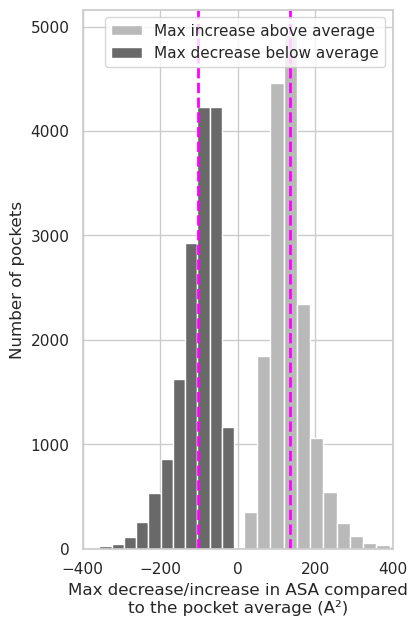

In [277]:
plt.figure(figsize=(4, 7))
sns.set(style="whitegrid")

max_diff = df_means['apol_pol_asa_diff_max-mean']
min_diff = df_means['apol_pol_asa_diff_min-mean']

plt.hist(max_diff, bins=15, alpha=1, label='Max increase above average', color="#B9B9B9")
plt.hist(min_diff, bins=15, alpha=1, label='Max decrease below average', color="#696969")

# Mean lines
plt.axvline(max_diff.mean(), color="magenta", linestyle='dashed', linewidth=2)
plt.axvline(min_diff.mean(), color="magenta", linestyle='dashed', linewidth=2)

plt.xlim(-400, 400)

plt.xlabel('Max decrease/increase in ASA compared\nto the pocket average (A²)')
plt.ylabel('Number of pockets')
plt.legend()
plt.show()


#### Volume

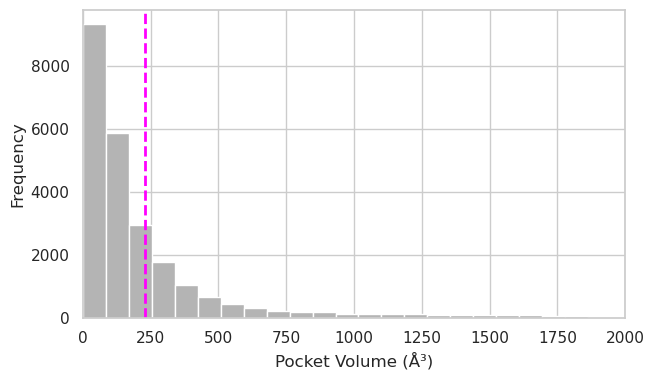

In [6]:
plt.figure(figsize=(7, 4))
sns.set(style="whitegrid")
# plt.title('Pocket Volume Distribution')
plt.xlabel('Pocket Volume (Å³)')
plt.ylabel('Frequency')
plt.hist(df_means['pock_volume'], bins=50, label='All Pocket Volumes', color="#B4B4B4")
plt.xlim(0, 2000)
plt.axvline(df_means['pock_volume'].mean(), color='magenta', linestyle='dashed', linewidth=2, label='Mean Pocket Volume')
# plt.legend()
plt.show()


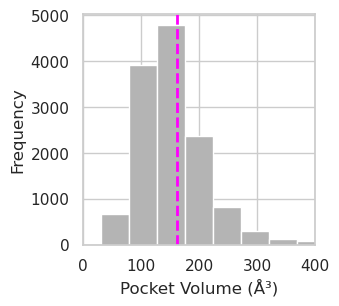

In [279]:
plt.figure(figsize=(3,3))
sns.set(style="whitegrid")
# plt.title('Pocket Volume Std Distribution')
plt.xlabel('Pocket Volume (Å³)')
plt.ylabel('Frequency')
plt.hist(df_std['pock_volume'], bins=25, label='All Pocket Volumes', color='#B4B4B4')
plt.xlim(0,400)
plt.axvline(df_std['pock_volume'].mean(), color='magenta', linestyle='dashed', linewidth=2, label='Mean Pocket Volume')
# plt.legend()
plt.show()